In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import print_function
from pixell import enmap
import numpy as np
import matplotlib.pyplot as plt
from pixell import enplot
import scipy
import pymaster as nmt

# File Loading and Plotting

In [3]:
point_source_mask_filename = "data/dr1/mask/car/mask_05.00arcmin_0.015Jy_new_car.fits" 
lmax_beam = 30000
nsplits = 4

# PA 1 -----
beam_filename = "data/dr1/beam/s14/pa1/beam_tform_160201_2014_pa1_jitter_CMB_deep56.txt"
mapname_head = "data/dr1/maps/car/s14/pa1/ACTPol_148_D56_PA1_S2_4way_split"
maps = [enmap.read_map(f"{mapname_head}{i}_I.fits") for i in range(nsplits)]
hits = [enmap.read_map(f"{mapname_head}{i}_hits.fits") for i in range(nsplits)]
point_source_mask = enmap.read_map(point_source_mask_filename)
# load in beams
beam_table = np.loadtxt(beam_filename)

print(maps[0].shape, maps[0].dtype)

(2182, 9455) float64


In [4]:
print(maps[0].wcs)

car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[4728,1325]}


## Map

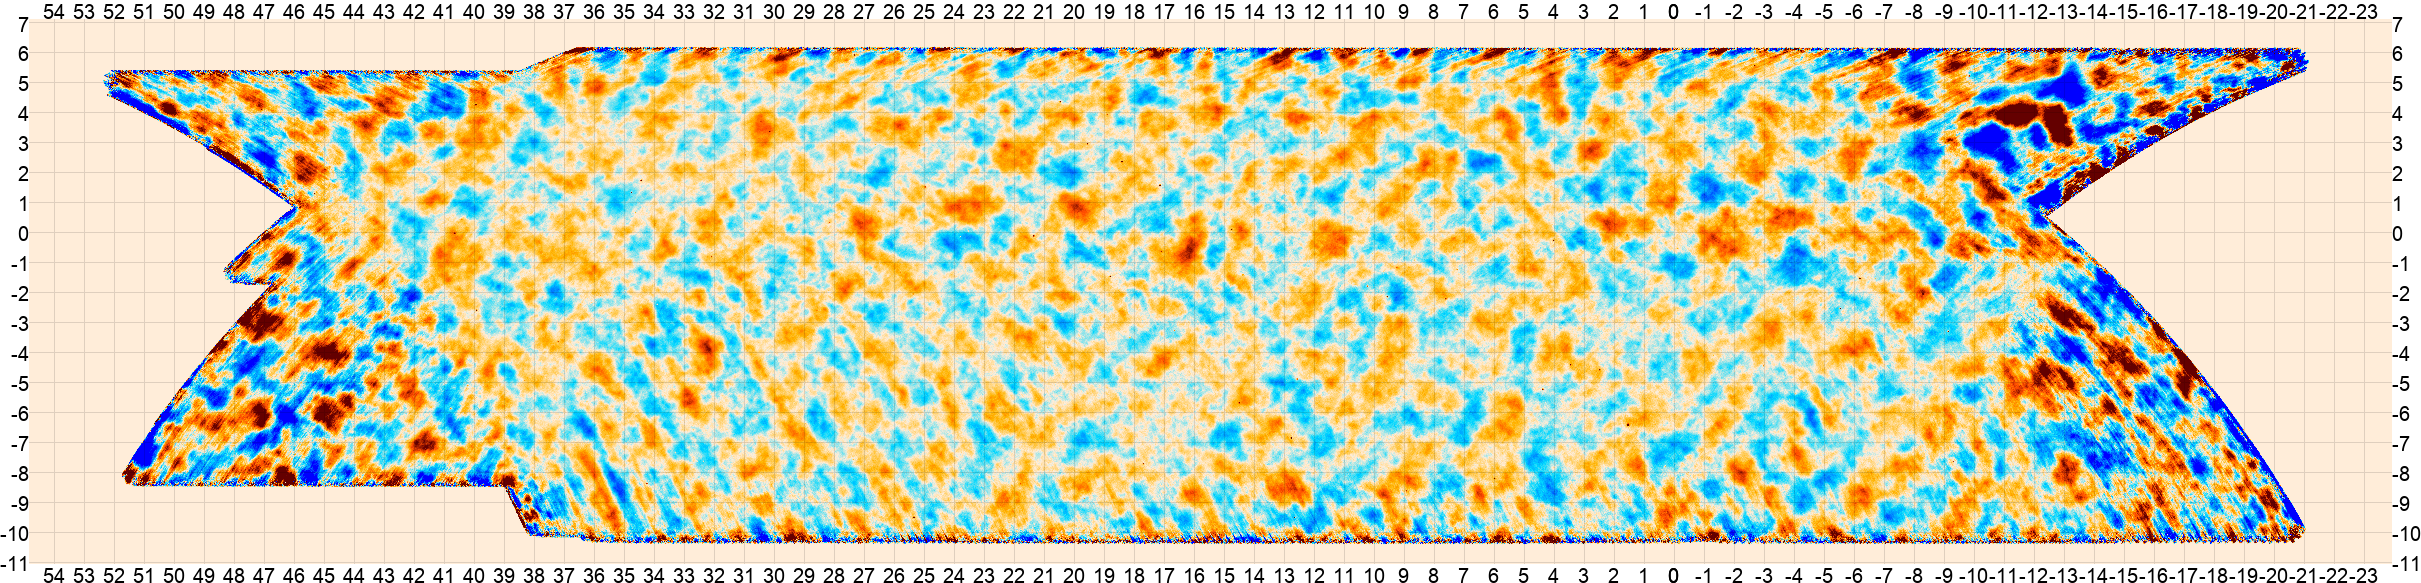

In [5]:
plots = enplot.get_plots(maps[0], range=1000, downgrade=4)
enplot.show(plots)

## Point Source Mask

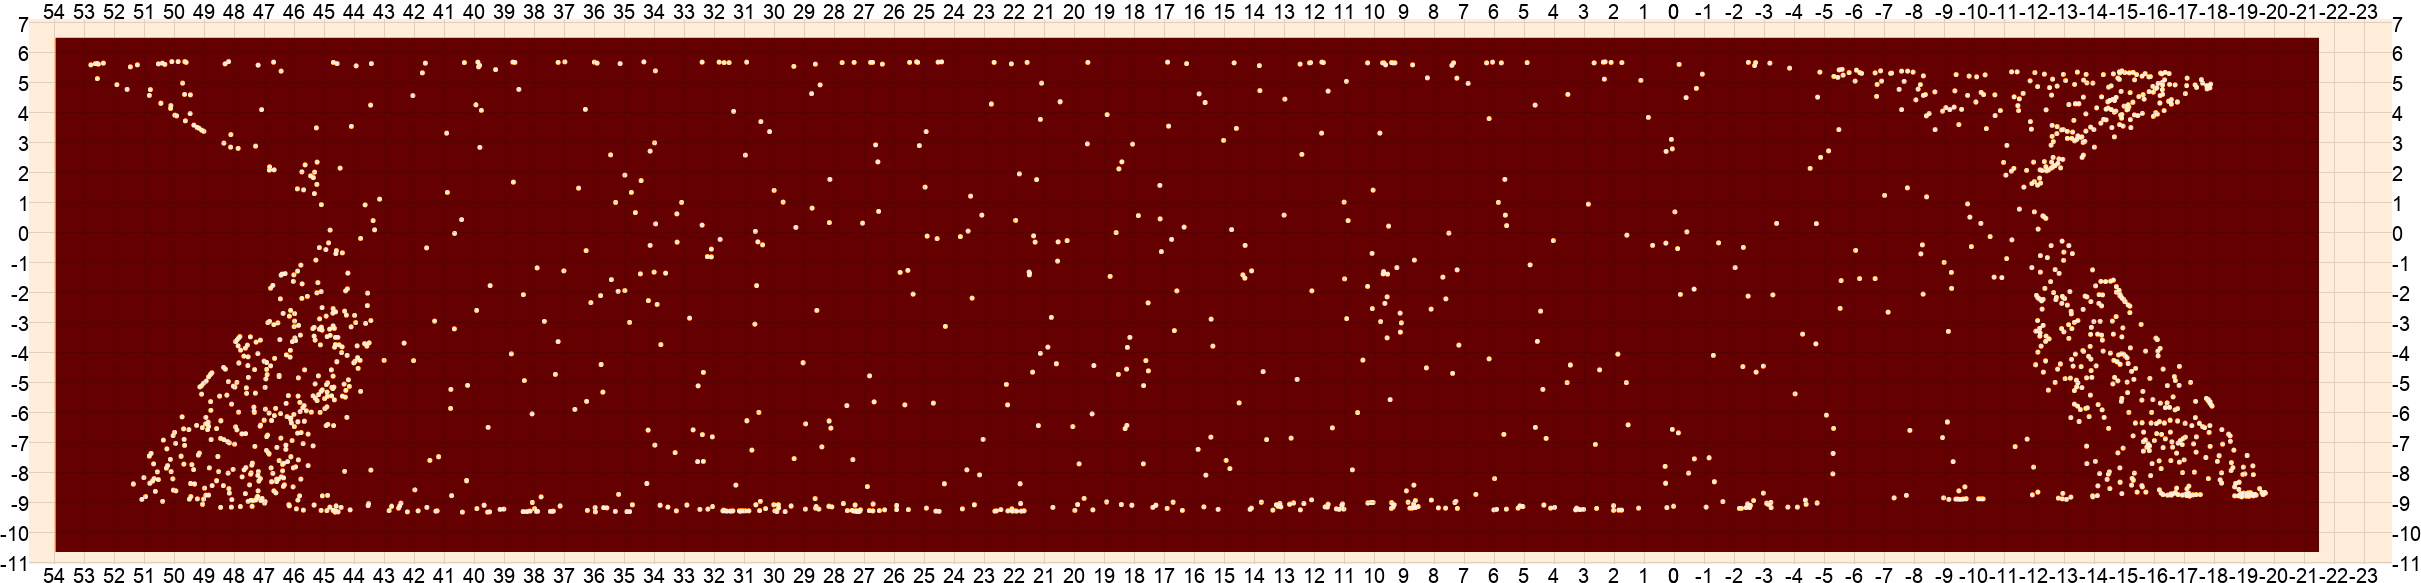

In [6]:
plots = enplot.get_plots(point_source_mask, range=1, downgrade=4)
enplot.show(plots)

## Hits

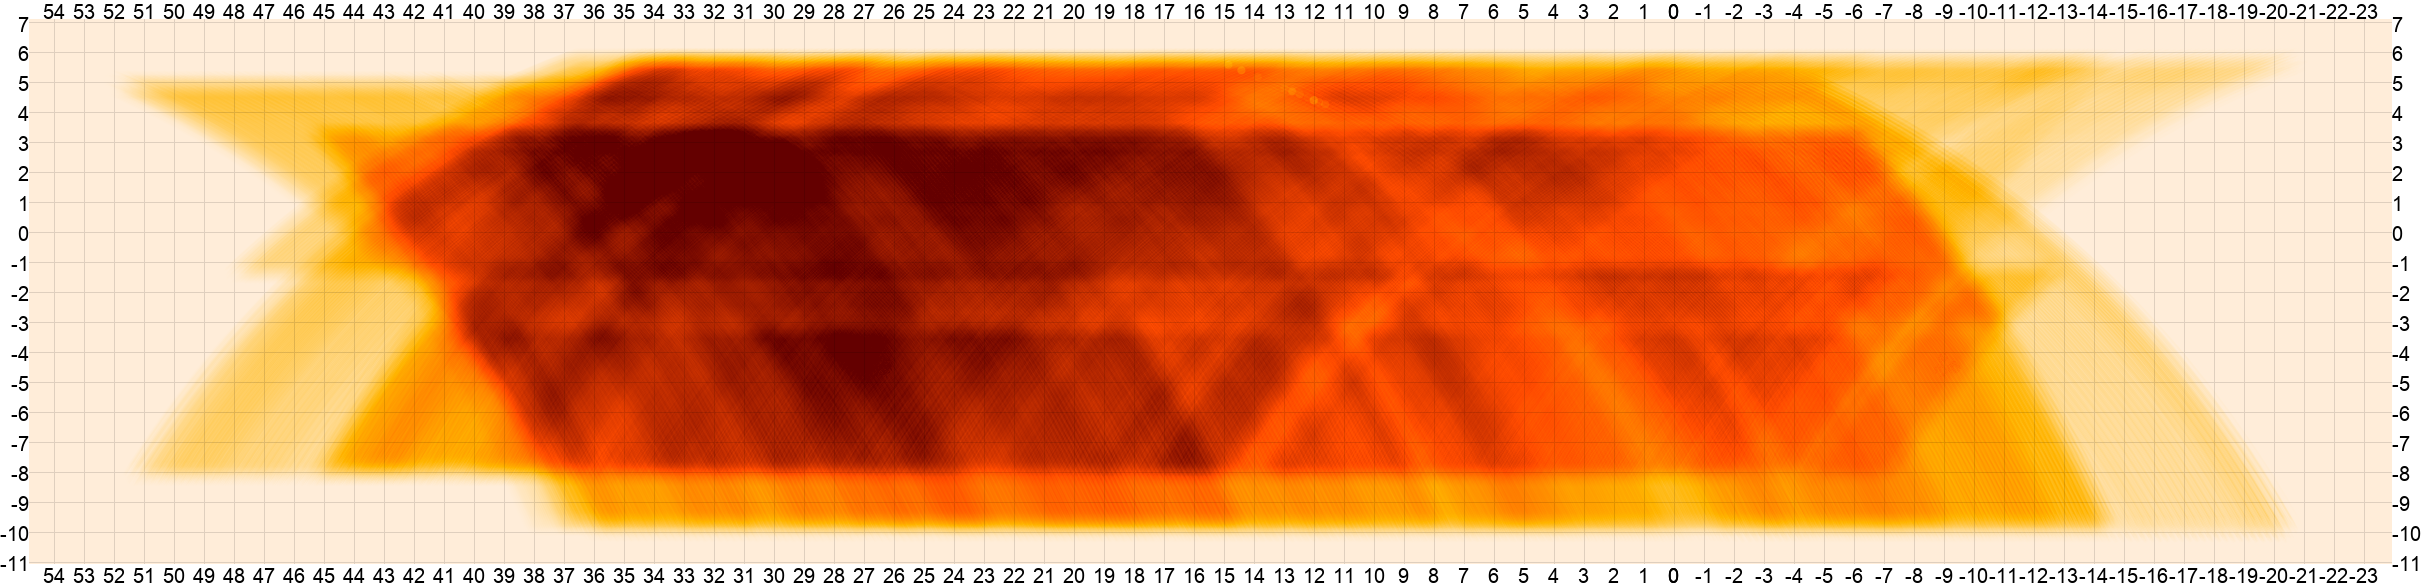

In [7]:
plots = enplot.get_plots(hits[0], range=5000, downgrade=4)
enplot.show(plots)

## Beam

Text(0, 0.5, '$B_{\\ell}$')

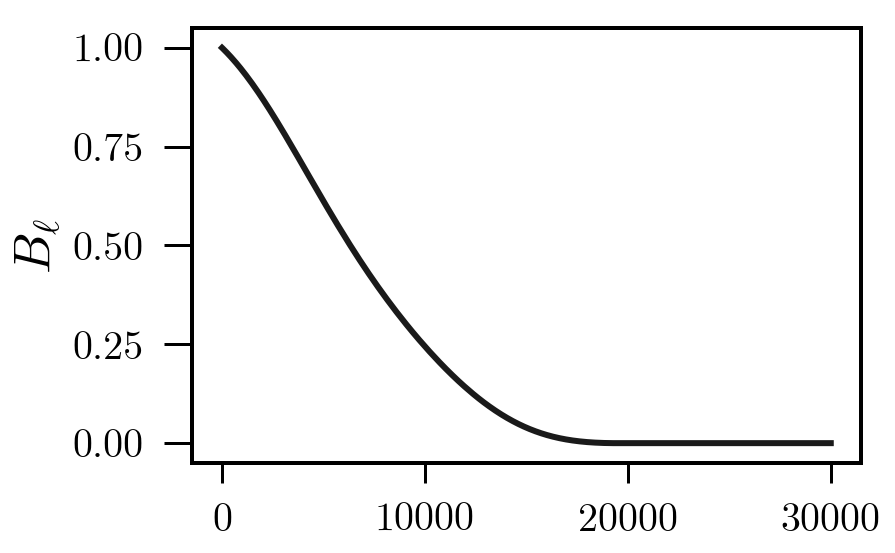

In [8]:
Bl = np.zeros(lmax_beam)
Bl[:beam_table.shape[0]] = beam_table[:,1].astype(float)
beams = [Bl] * nsplits

plt.plot( np.arange(lmax_beam), beams[0])
plt.ylabel(r"$B_{\ell}$")

# Apodization

We use the $C^2$ apodization for the point sources.

In [9]:
# adapted from PSpipe, which isn't python 3 yet
def get_distance(input_mask):
    pixSize_arcmin= np.sqrt(input_mask.pixsize()*(60*180/np.pi)**2)
    dist = scipy.ndimage.distance_transform_edt( np.asarray(input_mask) )
    dist *= pixSize_arcmin/60
    return dist

def apod_C2(input_mask,radius):
    """
    @brief C2 apodisation as defined in https://arxiv.org/pdf/0903.2350.pdf
    
    input_mask: enmap.ndmap with values \geq 0
    radius: apodization radius in degrees
    """
    
    if radius==0:
        return input_mask
    else:
        dist=get_distance(input_mask)
        id=np.where(dist > radius)
        win=dist/radius-np.sin(2*np.pi*dist/radius)/(2*np.pi)
        win[id]=1
        
    return( enmap.ndmap(win, input_mask.wcs) )

In [10]:
point_source_mask_apod_radius = 20.0 / 60.0 # degrees
apodized_point_source_mask = apod_C2(point_source_mask, point_source_mask_apod_radius)

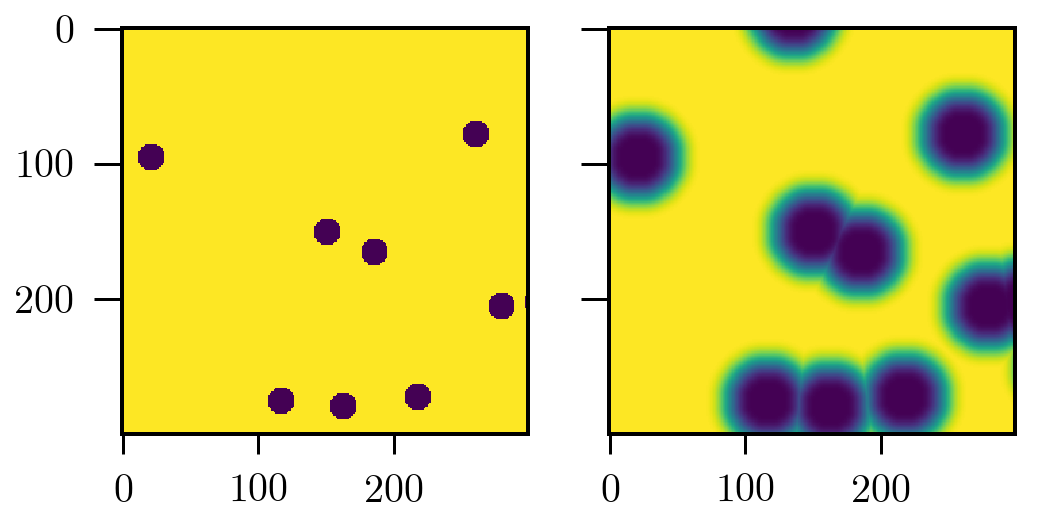

In [11]:
dec,ra = np.deg2rad(np.array((-2.38,33.92)))
width = np.deg2rad(150./60.)
box = np.array([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])

fig, axes = plt.subplots(1,2,figsize=(8,4), sharey=True)
axes[0].imshow(point_source_mask.submap(box))
axes[1].imshow(apodized_point_source_mask.submap(box))

In [12]:
masks = [hits_map * apodized_point_source_mask for hits_map in hits]

# Power Spectra with NaMaster

## Quick Test
We compute the cross spectrum of splits 0 and 1.

In [13]:
nlb = 50
niter = 0 # NaMaster-CAR only supports niter=0
lmax = 4000

field0 = nmt.NmtField(masks[0], [maps[0]], beam=beams[0], wcs=masks[0].wcs, n_iter=niter)
field1 = nmt.NmtField(masks[1], [maps[1]], beam=beams[1], wcs=masks[1].wcs, n_iter=niter)
cl_coupled = nmt.compute_coupled_cell(field0, field1)
b = nmt.NmtBin(2048, nlb=nlb, lmax=lmax)
lb = b.get_effective_ells()
w0 = nmt.NmtWorkspace()
w0.compute_coupling_matrix(field0,field1, b, n_iter=niter)
Cb = w0.decouple_cell(cl_coupled)

Text(0.5, 0, '$\\ell$')

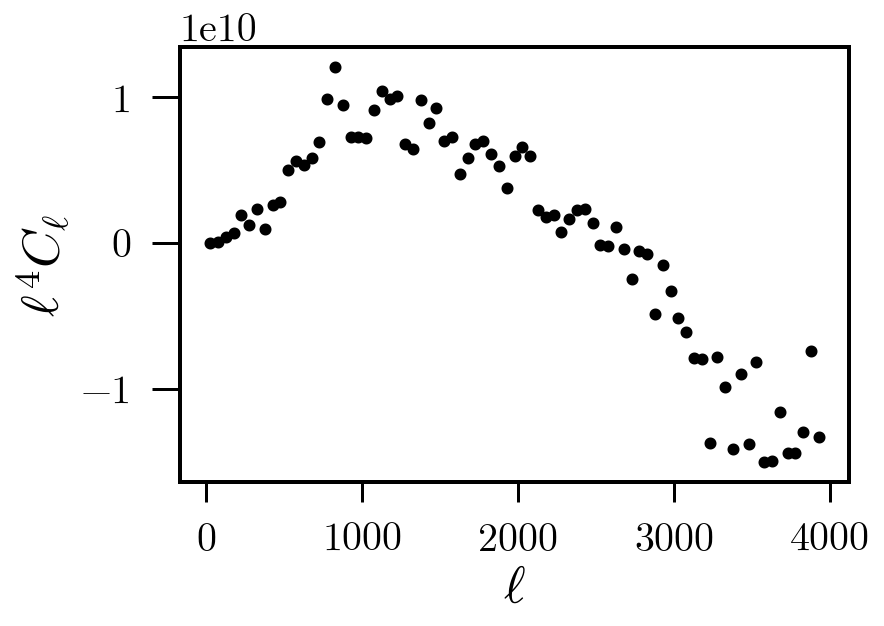

In [14]:
plt.plot( lb, Cb[0] * lb**4, 'ko' )
plt.ylabel(r"$\ell^4 C_{\ell}$")
plt.xlabel(r"$\ell$")

## All Splits

In [28]:
ps_dict = {}
cross_spectra = []
fields = [nmt.NmtField(masks[i], [maps[i]], beam=beams[i], wcs=masks[i].wcs, n_iter=niter)
         for i in range(nsplits)]

# we can reuse the workspace w0 from earlier
for i in range(nsplits):
    for j in range(nsplits):
        if i > j:
            cl_coupled = nmt.compute_coupled_cell(fields[i], fields[j])
            b = nmt.NmtBin(2048, nlb=nlb, lmax=lmax)
            lb = b.get_effective_ells()
            Cb = w0.decouple_cell(cl_coupled)
            ps_dict[f"{i},{j}"] = Cb
            cross_spectra += [Cb[0]]

We can do a poor cosmologist's error bar by taking the standard errors of the cross spectra from the splits.

In [29]:
mean_Cltt = np.sum(cross_spectra, axis=0) / len(cross_spectra)
se_Cltt = np.std(cross_spectra, axis=0)/np.sqrt(len(cross_spectra))

(0, 3000)

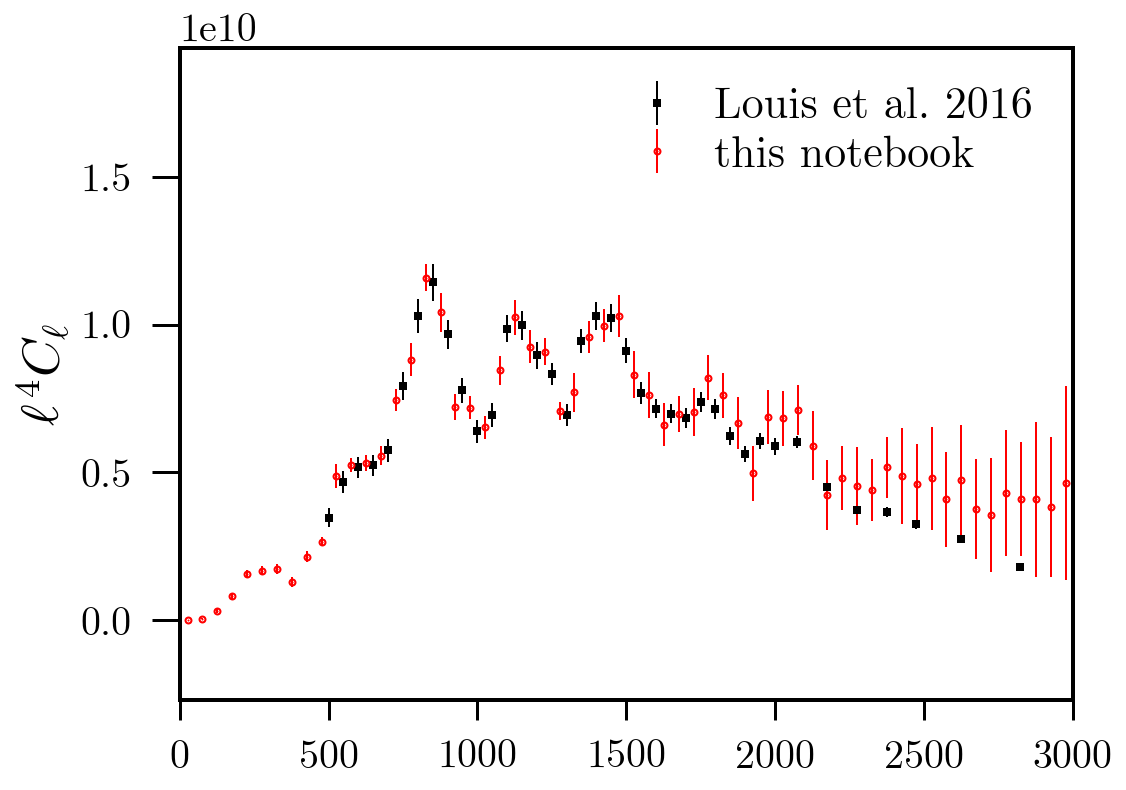

In [30]:
plt.figure(figsize=(8,6))
actual_cltt = np.loadtxt("data/cl_cmb_tt.dat")
plt.errorbar( actual_cltt[:40,0] , actual_cltt[:40,1] *  actual_cltt[:40,0]**4, 
             yerr = actual_cltt[:40,2]*actual_cltt[:40,0]**4, fmt='ks', lw=1, ms=1, label="Louis et al. 2016" )

plt.errorbar(lb, mean_Cltt * lb**4, 
             fmt='ro', yerr=se_Cltt * lb**4,
             lw=1, ms=1, label="this notebook")
plt.ylabel(r"$\ell^4 C_{\ell}$")
plt.legend()
plt.xlim(0,3000)